In [12]:
import numpy as np
from scipy.special import binom
import matplotlib.pyplot as plt
import itertools
import os

'''
Assumptions: 
    free energies for nucleaation and coil-helix transition are not temperature dependent
    T dependency through weights, s and sigma
    partition sum is T dependent
'''

class ZimmBragg:
    
    def __init__(self, s, sigma, nres=15, ref_temp = 298):
        self.R = 8.314463    # J/(K mol)
        # G of h->c and nucleation (unit: J/mol)
        self.G_hc = -self.R*ref_temp*np.log(s)
        self.G_nuc = -self.R*ref_temp*np.log(sigma)
        self.nres = nres
                
    def partition_sum(self, temp):
        s = np.exp(-self.G_hc/(self.R * temp))
        sigma = np.exp(-self.G_nuc/(self.R * temp))
        l = np.array([0, 1])
        r = np.array([[1, 1]]).T
        W = np.array([[s, 1], [sigma * s, 1]])
        W_prod = np.linalg.matrix_power(W, self.nres)
        self.Z = l@W_prod@r

    def free_energy_profile(self, temps, out=True):
        # store probabilities of macrostate nh as function of T
        self.probs = np.zeros((len(temps), self.nres+1))        
        self.G_profile = np.zeros((len(temps), self.nres+1))
        for i, temp in enumerate(temps):
            self.partition_sum(temp)
            for n in range(self.nres+1):
                G_n, prob_n = self.free_energy_nhelix(temp, n)
                self.G_profile[i, n] = G_n
                self.probs[i, n] = prob_n
        if out==True:
            return self.G_profile

    def free_energy_nhelix(self, temp, nhelix):
        if nhelix == 0:
            return 1/self.Z, 1/self.Z
        else:
            # maximum v (number of helix stretches separated by at least 1 coil)
            if self.nres % 2 == 0:
                max_v = int(self.nres/2)
            else:
                max_v = int((self.nres+1)/2)
            G_tot = 0
            prob_tot = 0
            all_gnv = binom(self.nres, nhelix)
            for v in range(1, np.min([nhelix, max_v])+1):                
                # g_nv is number of possible combinations to have nhelix in helix
                # from https://pubs.aip.org/aip/jcp/article/38/4/934/207167/On-the-Helix-Coil-Equilibrium-in-Polypeptides eq. 8, µ=1
                g_nv = binom(nhelix-1, v-1) * binom(self.nres-nhelix+1, v)
                all_gnv -= g_nv
                # G for every microstate described by (n,v)
                G_nv = nhelix * self.G_hc + v * self.G_nuc
                # statistical weight of (n,v) microstate
                prob_nv = g_nv * np.exp(-G_nv/(temp*self.R)) / self.Z
                G_tot += G_nv * prob_nv
                prob_tot += prob_nv
            if all_gnv != 0:
                print(f"Warning: Not all states considered: {all_gnv} states missing!!")
            return G_tot, prob_tot
    
    def thermal_unfolding_curves(self, temps):
        # calculate probabilities for given temperatures
        self.free_energy_profile(temps, out=False)
        # take updated probs and calculate fractional helicities
        fract_hel, melting_temp = fractional_helicities(self.probs, temps)
        return fract_hel, melting_temp
        

class ZimmBragg_2s:
    
    def __init__(self, s_h, s_c, res_class, sigma, nres=15, ref_temp=298):
        self.res_class = res_class
        self.nres = nres
        self.R = 8.314463    # J/(K mol)
        # G of h->c and nucleation (unit: J/mol), no T-dependency
        self.G_hc_h = -self.R*ref_temp*np.log(s_h)
        self.G_hc_c = -self.R*ref_temp*np.log(s_c)
        self.G_nuc = -self.R*ref_temp*np.log(sigma)
        
    def partition_sum(self, temp):
        sh = np.exp(-self.G_hc_h/(self.R * temp))
        sc = np.exp(-self.G_hc_c/(self.R * temp))
        sigma = np.exp(-self.G_nuc/(self.R * temp))
        l = np.array([0, 1])
        r = np.array([[1, 1]]).T
        W_h = np.array([[sh, 1], [sigma * sh, 1]])
        W_c = np.array([[sc, 1], [sigma * sc, 1]])
        W_prod = np.identity(2)
        for i in range(self.nres):
            if self.res_class[i] == 1:
                W_prod = W_prod@W_h
            elif self.res_class[i] == 0:
                W_prod = W_prod@W_c
            else:
                print("Warning: Only 0 and 1 allowed to classify state!")
        self.Z = l@W_prod@r
    
    def free_energy_profile(self, temps, out=True):
        
        # store probabilities of macrostate nh as function of T
        self.probs = np.zeros((len(temps), self.nres+1))
        microstates = self.microstates_data()
        
        G_profile = np.zeros((len(temps), self.nres+1))
        for i, temp in enumerate(temps):
            self.partition_sum(temp)
            for n in range(self.nres+1):
                # select the microstates which have n helices
                nh_arrays = [[microstates[:, i]] for i in range(np.shape(microstates)[1]) if microstates[0, i] == n]
                microstates_nh = np.concatenate(nh_arrays)
                G_profile[i, n], self.probs[i, n] = self.free_energy_nhelix(temp, microstates_nh)
        if out == True:
            return G_profile

    def microstates_data(self):
        # get 4 parameters of all microstates: number of helices in s_h, s_c region & 
        # number of stretches in sequence, number of helices
        all_combs = list(itertools.product([0, 1], repeat=self.nres))
        all_combs = np.array(all_combs)
        n_h = np.sum(all_combs, axis=-1)
        n_h_sh = all_combs @ self.res_class.T
        n_h_sc = n_h - n_h_sh
        all_v = np.zeros_like(all_combs[:, 0])
        for i, row in enumerate(all_combs):
            tmp = np.concatenate(([0], row, [0]))
            tmp = np.diff(tmp)
            v = np.sum(tmp == 1)
            all_v[i] = v
        params = np.array([n_h, n_h_sh, n_h_sc, all_v])
        return params

    def free_energy_nhelix(self, temp, ms_data):
        if ms_data[0, 0] == 0:
            return 1/self.Z, 1/self.Z
        else:            
            # G of every microstate
            G_params = np.array([0, self.G_hc_h, self.G_hc_c, self.G_nuc])
            G_ms = ms_data @ G_params
            #weights = self.s_h**ms_data[:, 1] * self.s_c**ms_data[:, 2] * self.sigma**ms_data[:, 3]
            prob = np.exp(-G_ms/(self.R * temp)) / self.Z
            G_tot = G_ms @ prob
            prob_tot = np.sum(prob)
            return G_tot, prob_tot    
    
    def thermal_unfolding_curves(self, temps):
        # calculate probabilities for given temperatures
        self.free_energy_profile(temps, out=False)
        # take updated probs and calculate fractional helicities
        fract_hel, melting_temp = fractional_helicities(self.probs, temps)
        return fract_hel, melting_temp

def fractional_helicities(probs, temps):
    nres_p1 = np.shape(probs)[1]
    nh = np.linspace(0, nres_p1-1, nres_p1)   
    fract_hel = probs @ nh / (nres_p1-1)
    melting_temp = "Not reached"
    for a in range(len(fract_hel)):
        if np.linalg.norm(fract_hel[a] - 0.5) < 0.1:
            melting_temp = temps[a]
            break
        
    return fract_hel, melting_temp
                
def plot_Gprofile(G_values, nres=15, title=None, labels=None, output=None):
    
    x = range(nres+1)
    if labels is None:
        plt.plot(x, G_values.T)
    else:
        for g, lab in zip(G_values, labels):
            plt.plot(x, g, label=lab)
        plt.legend()
    plt.xlabel("number of helix residues")
    plt.ylabel("G [J/mol]")
    if title:
        plt.title(title)  
    if output:
        os.makedirs('./plots', exist_ok=True)
        plt.savefig(f"./plots/{output}")
    plt.show()   
    
    

In [13]:
NRES = 15
SIGMA = 1e-3

s_high = np.linspace(1, 2, 11)
t_values = np.linspace(278, 368, 6)

/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.G_profile[i, n] = G_n
/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.probs[i, n] = prob_n


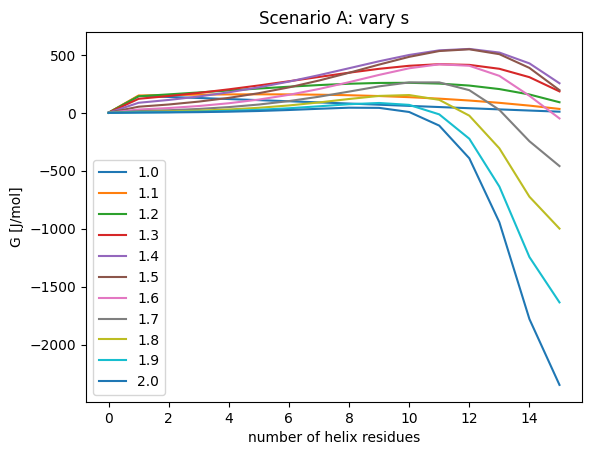

In [14]:
G_highs_T278 = np.zeros((len(s_high), NRES+1))
for i, s in enumerate(s_high):
    zb_a1 = ZimmBragg(s, SIGMA, NRES)
    G_highs_T278[i, :] = zb_a1.free_energy_profile(temps=[278])
plot_Gprofile(G_highs_T278, output="ZB_A_varyS", title="Scenario A: vary s", 
              labels=[f"{s:.1f}" for s in s_high], nres=NRES)


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.G_profile[i, n] = G_n
/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.probs[i, n] = prob_n


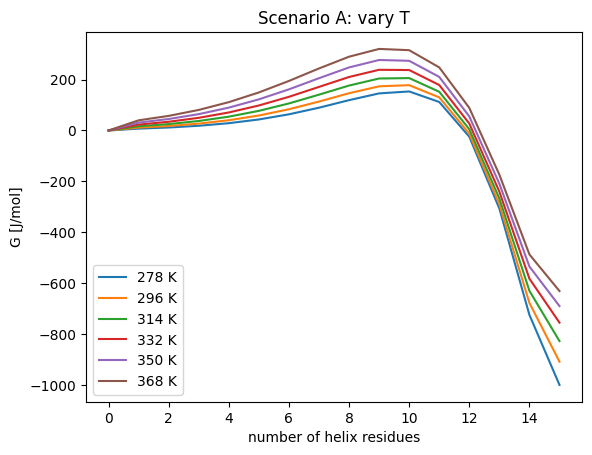

In [45]:
zb_a2 = ZimmBragg(1.8, SIGMA, NRES)
t_values = np.linspace(278, 368, 6)
G_T_s10 = zb_a2.free_energy_profile(temps=t_values)
plot_Gprofile(G_T_s10, title="Scenario A: vary T", output="ZB_A_varyT", 
              labels=[f"{t:.0f} K" for t in t_values], nres=NRES)

In [16]:
s_low = np.linspace(0.1, 1.0, 10)
t_values = np.linspace(278, 368, 6)

/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.G_profile[i, n] = G_n
/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.probs[i, n] = prob_n


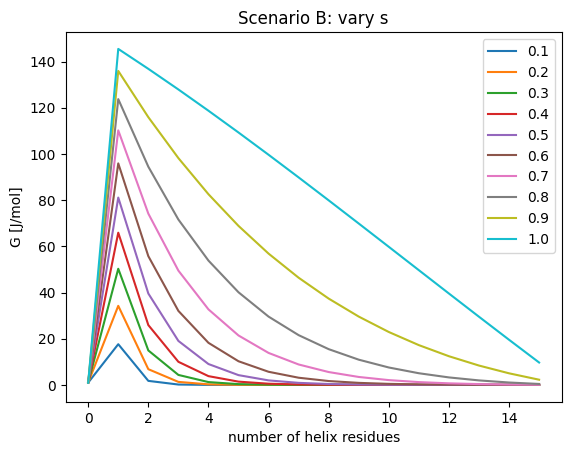

In [17]:
G_lows_T278 = np.zeros((len(s_low), NRES+1))
for i, s in enumerate(s_low):
    zb_b1 = ZimmBragg(s, SIGMA, NRES)
    G_lows_T278[i, :] = zb_b1.free_energy_profile(temps=[278])
plot_Gprofile(G_lows_T278, output="ZB_B_varyS", title="Scenario B: vary s", 
              labels=[f"{s:.1f}" for s in s_low])


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.G_profile[i, n] = G_n
/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.probs[i, n] = prob_n


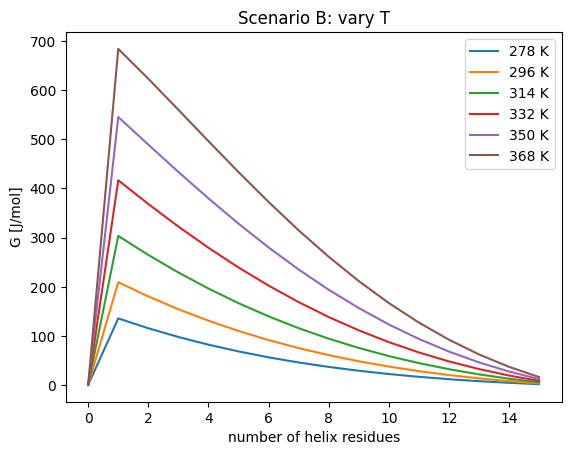

In [29]:
zb_b2 = ZimmBragg(0.9, SIGMA, NRES)
G_T_s01 = zb_b2.free_energy_profile(temps=t_values)
plot_Gprofile(G_T_s01, title="Scenario B: vary T", output="ZB_B_varyT", 
              labels=[f"{t:.0f} K" for t in t_values])

/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G_profile[i, n], self.probs[i, n] = self.free_energy_nhelix(temp, microstates_nh)


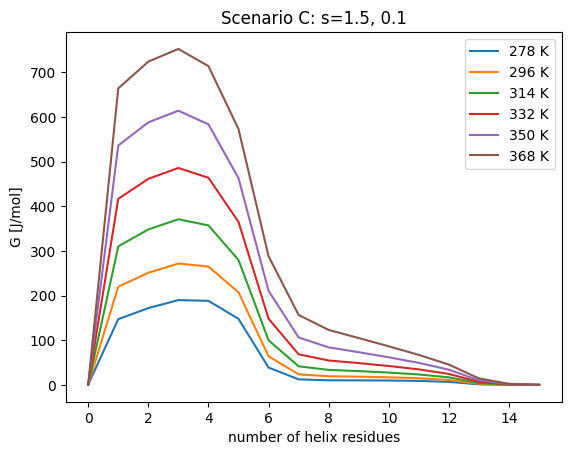

In [19]:
s_h = 1.5
s_c = 0.1
t_values = np.linspace(278, 368, 6)
# 1 for helix, 0 for helix
residues = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0])

zb_c1 = ZimmBragg_2s(s_h, s_c, residues, SIGMA, NRES)
G_2s_T = zb_c1.free_energy_profile(temps=t_values)  
plot_Gprofile(G_2s_T, title=f"Scenario C: s={s_h}, {s_c}", output="ZB_C",
              labels=[f"{t:.0f} K" for t in t_values])

s     Melting Temperatures
1e-05 Not reached
0.0001 Not reached
0.001 Not reached
0.01 Not reached
0.1 Not reached
1.0 759.1836734693878
10.0 Not reached
100.0 Not reached
1000.0 Not reached
10000.0 Not reached


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.G_profile[i, n] = G_n
/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.probs[i, n] = prob_n


100000.0 Not reached


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_6923/894250083.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G_profile[i, n], self.probs[i, n] = self.free_energy_nhelix(temp, microstates_nh)


2S 1146.938775510204


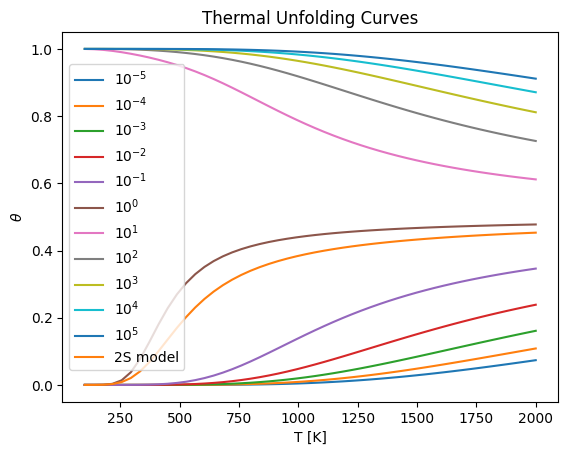

In [20]:
t_values = np.linspace(100, 2000, 50)
s_values = np.logspace(-5, 5, 11)
s_lab = np.linspace(-5, 5, 11)
print("s     Melting Temperatures")
for s, sl in zip(s_values, s_lab):
    zb = ZimmBragg(s, SIGMA)
    fracs, melt_temp = zb.thermal_unfolding_curves(t_values)
    plt.plot(t_values, fracs, label = f"10$^{{{sl:.0f}}}$")
    print(s, melt_temp)
fracs, melt_temp = zb_c1.thermal_unfolding_curves(t_values)
print("2S", melt_temp)
plt.plot(t_values, fracs, label="2S model")
plt.legend()
plt.title("Thermal Unfolding Curves")
plt.xlabel("T [K]")
plt.ylabel(r"$\theta$")
plt.savefig("./plots/ThermalUnfolding.png")
plt.show()
